<a href="https://colab.research.google.com/github/EdenNguyenDo/Australia-vehicles-classification/blob/main/fine_tune_florence_2_vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture
!pip install timm flash_attn einops;

In [2]:
%%bash
git clone https://github.com/EdenNguyenDo/Australia-vehicles-classification.git


Cloning into 'Australia-vehicles-classification'...


In [4]:
cd Australia-vehicles-classification

/content/Australia-vehicles-classification


Now we import the packages we'll need, including the `utils.py` module from the repository that we just cloned. This file provides misellaneous functionality to make it easier to work with Florence-2.

In [5]:
import copy

from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests

import utils



%matplotlib inline

Next we load the Florence-2 model and processor

In [6]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


And then we set these models as constants for our `utils.py` module so that the functions can utilize them as global constants.

In [7]:
utils.set_model_info(model, processor)

LOAD IMAGES

In [11]:
path = "dataset/train/frame2.png"
image = Image.open(path)
image_rgb = Image.open(path).convert("RGB")

#### Object detection

Object detection automatically detects the salient objects in an image. Florence-2 supports 3 levels of semantic granularity:
1. None (bounding boxes only)
2. Categorical labels
3. Descriptive labels

<OD>


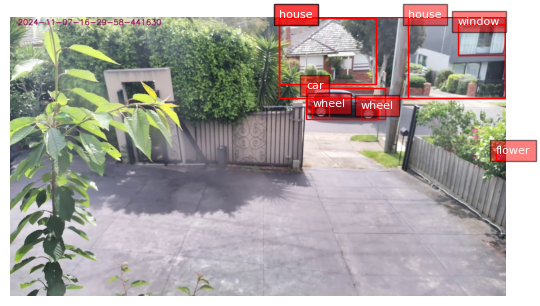

In [12]:
tasks = [#utils.TaskType.REGION_PROPOSAL,
         utils.TaskType.OBJECT_DETECTION
         #utils.TaskType.DENSE_REGION_CAPTION,
         ]

for task in tasks:
  results = utils.run_example(task, image_rgb)
  print(task.value)
  utils.plot_bbox(results[task], image)

# FINE TUNING FLORENCE 2 AND TRAIN ON A CUSTOM DATASET

In [13]:
!pip install -q roboflow git+https://github.com/roboflow/supervision.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [21]:
# @title Imports

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

In [23]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [16]:
# @title Define `DetectionsDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [38]:
# @title Initiate `DetectionsDataset` and `DataLoader` for train and validation subsets

BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    images = [image.convert('RGB') for image in images]
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = "dataset/train/annotation.jsonl",
    image_directory_path = "dataset/train/"
)
val_dataset = DetectionDataset(
    jsonl_file_path = "dataset/valid/annotation.jsonl",
    image_directory_path = "dataset/valid/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

### Setup LoRA Florence-2 model


LoRA is low-rank decomposition method to reduce the number of trainable parameters which speeds up finetuning large models and uses less memory.

In [39]:
# @title Config Lora
config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


In [40]:
torch.cuda.empty_cache()


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


TypeError: 'NoneType' object is not iterable

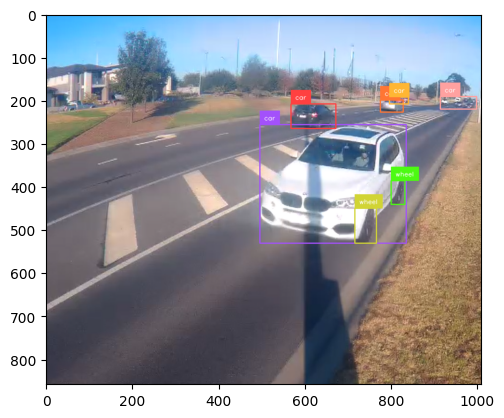

In [48]:
# @title Run inference with pre-trained Florence-2 model on validation dataset

def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='png')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/png;base64,{image_b64}"


def render_example(image: Image.Image, response):
    # try:
      detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
      image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
      image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
      if detections is not None:
        utils.plot_bbox(detections, image)
      # except:
      #print('failed to render model response')
      return f"""


      {html.escape(json.dumps(response))}
      """


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        # Ensure the image is in RGB format and has the correct shape.
        image = image.convert('RGB')  # Convert to RGB format

        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        if answer is not None:
          html_out += render_example(image, answer)
    print(html_out)
    # display(HTML(html_out))

render_inference_results(peft_model, val_dataset, 4)

In [36]:

# @title Define train loop

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results(peft_model, val_loader.dataset, 6)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

In [41]:
# @title Run train loop

%%time

EPOCHS = 10
LR = 5e-6

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response
failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 1/10: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Average Training Loss: 8.947503089904785


Validation Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Average Validation Loss: 9.411639213562012


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response
failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
Training Epoch 2/10: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Average Training Loss: 8.036624670028687


Validation Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Average Validation Loss: 9.33957576751709


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response
failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 3/10: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Average Training Loss: 8.611493349075317


Validation Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Average Validation Loss: 9.28174114227295


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response
failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 4/10: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Average Training Loss: 8.61076831817627


Validation Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Average Validation Loss: 9.232539176940918


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response
failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 5/10: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Average Training Loss: 8.51333475112915


Validation Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Average Validation Loss: 9.19127368927002


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response
failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 6/10: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Average Training Loss: 8.656352043151855


Validation Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Average Validation Loss: 9.158478736877441


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response
failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 7/10: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Average Training Loss: 8.449559688568115


Validation Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Average Validation Loss: 9.132861137390137


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response
failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 8/10: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Average Training Loss: 7.6176886558532715


Validation Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Average Validation Loss: 9.11455249786377


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response
failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 9/10: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Average Training Loss: 8.465206146240234


Validation Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Average Validation Loss: 9.102993965148926


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response
failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 10/10: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Average Training Loss: 8.260792255401611


Validation Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Average Validation Loss: 9.097969055175781


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


failed to redner model response
failed to redner model response


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


CPU times: user 40.9 s, sys: 3.68 s, total: 44.6 s
Wall time: 43.6 s
